In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from functools import reduce
import calendar


In [3]:
df = pd.read_csv('hotel_bookings_clean.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118087 entries, 0 to 118086
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118087 non-null  object 
 1   is_canceled                     118087 non-null  bool   
 2   lead_time                       118087 non-null  int64  
 3   arrival_date_month              118087 non-null  object 
 4   stays_in_weekend_nights         118087 non-null  int64  
 5   stays_in_week_nights            118087 non-null  int64  
 6   adults                          118087 non-null  int64  
 7   children                        118087 non-null  int64  
 8   babies                          118087 non-null  int64  
 9   meal                            118087 non-null  object 
 10  market_segment                  118087 non-null  object 
 11  distribution_channel            118087 non-null  object 
 12  is_repeated_gues

In [5]:
print(df['reservation_status'].value_counts())

reservation_status
Check-Out    73973
Canceled     42925
No-Show       1189
Name: count, dtype: int64


In [6]:
cancelations = (df['reservation_status'] == 'Canceled').sum()
print(cancelations)

42925


In [7]:
total_bookings = df.shape[0]
print(total_bookings)

118087


In [8]:
cancelation_rate = cancelations / total_bookings
print(cancelation_rate)

0.36350317985891756


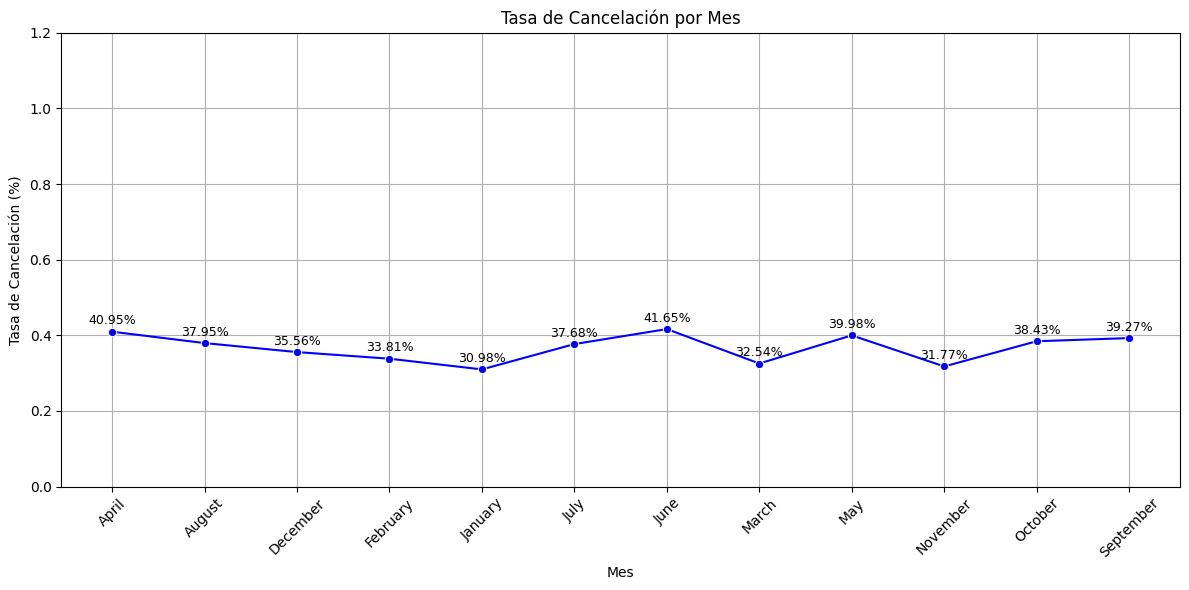

In [9]:
# Asegurar que 'arrival_date_month' sea el índice correcto para la gráfica
monthly_cancellation = df.groupby("arrival_date_month", observed=True).agg(
    total_bookings=("is_canceled", "count"), 
    cancellations=("is_canceled", "sum")
)
monthly_cancellation["cancellation_rate"] = (monthly_cancellation["cancellations"] / monthly_cancellation["total_bookings"])

# Paso 3: Visualización con ajuste de índice
plt.figure(figsize=(12, 6))

# Dibujar la línea con marcadores
sns.lineplot(data=monthly_cancellation, x=monthly_cancellation.index, y="cancellation_rate", marker="o", color="blue")

# Añadir etiquetas de porcentaje encima de cada punto
for i in range(len(monthly_cancellation)):
    porcentaje = monthly_cancellation['cancellation_rate'].iloc[i] * 100  # Usar .iloc para acceder por posición
    plt.text(
        x=monthly_cancellation.index[i],
        y=monthly_cancellation['cancellation_rate'].iloc[i] + 0.02,  # Ajuste vertical
        s=f"{porcentaje:.2f}%",  # Formato porcentaje con 2 decimales
        ha='center',
        fontsize=9,
        color='black'
    )

# Personalización del gráfico
plt.title("Tasa de Cancelación por Mes")
plt.ylabel("Tasa de Cancelación (%)")
plt.xlabel("Mes")
plt.xticks(rotation=45)
plt.ylim(0, 1.2)  # Dejar espacio para etiquetas
plt.grid(True)
plt.tight_layout()
plt.show()


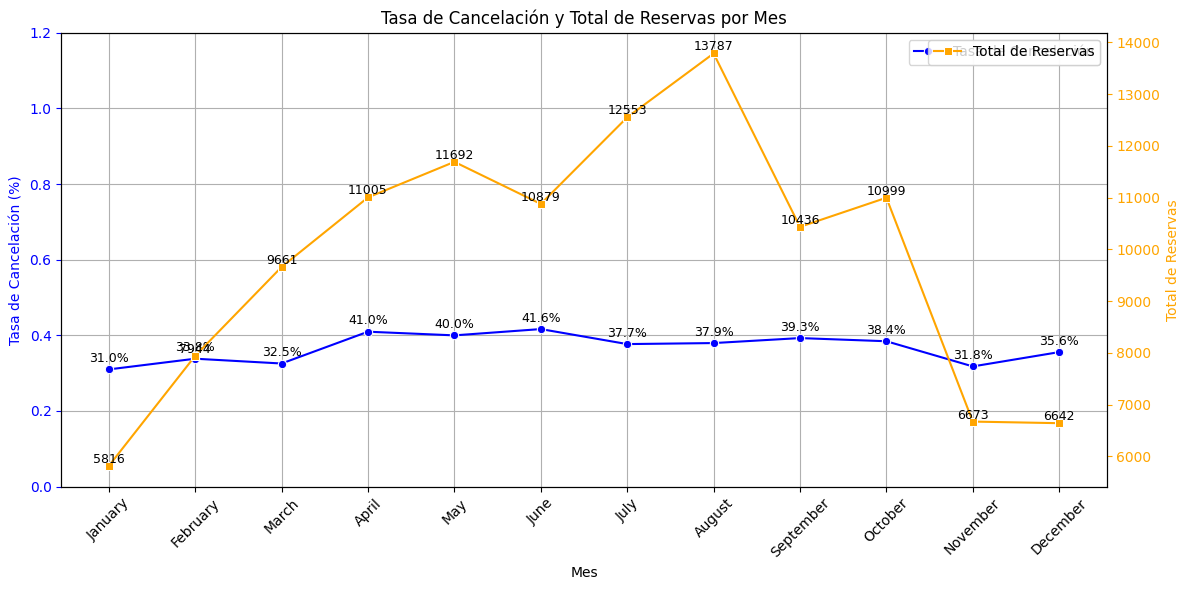

In [10]:
# 2. Asegurar orden correcto de meses y convertir en categoría ordenada
month_order = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']
df['arrival_date_month'] = pd.Categorical(
    df['arrival_date_month'],
    categories=month_order,
    ordered=True
)

# 3. Cálculo de tasa de cancelación y total de reservas por mes
monthly = (
    df
    .groupby('arrival_date_month', observed=False)  # evita el FutureWarning
    .agg(
        cancellation_rate=('is_canceled', 'mean'),
        total_reservations=('is_canceled', 'size')
    )
    .reset_index()
)

# 4. Gráfico con doble eje Y
fig, ax1 = plt.subplots(figsize=(12, 6))

# 4a. Tasa de cancelación (eje izquierdo)
sns.lineplot(
    ax=ax1,
    data=monthly,
    x='arrival_date_month',
    y='cancellation_rate',
    marker='o',
    color='blue',
    label='Tasa de Cancelación'
)
# Etiquetas de porcentaje
for idx, row in monthly.iterrows():
    ax1.text(
        idx,
        row.cancellation_rate + 0.02,
        f"{row.cancellation_rate*100:.1f}%",
        ha='center',
        fontsize=9,
        color='black'
    )
ax1.set_ylabel('Tasa de Cancelación (%)', color='blue')
ax1.tick_params(axis='y', colors='blue')
ax1.set_ylim(0, 1.2)

# 4b. Total de reservas (eje derecho)
ax2 = ax1.twinx()
sns.lineplot(
    ax=ax2,
    data=monthly,
    x='arrival_date_month',
    y='total_reservations',
    marker='s',
    color='orange',
    label='Total de Reservas'
)
# Etiquetas de total de reservas
for idx, row in monthly.iterrows():
    ax2.text(
        idx,
        row.total_reservations,
        f"{row.total_reservations}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )
ax2.set_ylabel('Total de Reservas', color='orange')
ax2.tick_params(axis='y', colors='orange')

# 5. Personalización común
ax1.set_xlabel('Mes')
plt.title('Tasa de Cancelación y Total de Reservas por Mes')
ax1.set_xticks(range(len(monthly)))
ax1.set_xticklabels(monthly['arrival_date_month'], rotation=45)
ax1.grid(True)

plt.tight_layout()
plt.show()

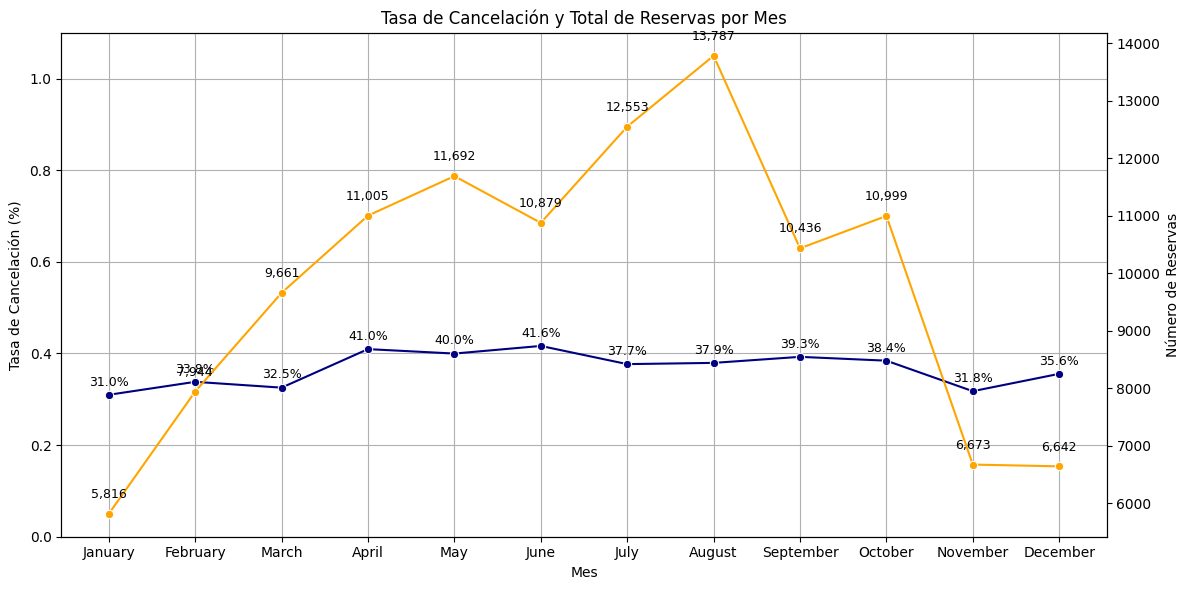

In [11]:
# Asegurar orden cronológico de los meses
month_map = {
    'January': 1, 'February': 2, 'March': 3,
    'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9,
    'October': 10, 'November': 11, 'December': 12
}

monthly_cancellation = monthly_cancellation.reset_index()
monthly_cancellation["month_num"] = monthly_cancellation["arrival_date_month"].map(month_map)
monthly_cancellation = monthly_cancellation.sort_values("month_num")

# Crear figura y eje principal
fig, ax1 = plt.subplots(figsize=(12, 6))

# Línea: tasa de cancelación
sns.lineplot(
    data=monthly_cancellation,
    x="arrival_date_month",
    y="cancellation_rate",
    marker="o",
    color="navy",
    ax=ax1
)
ax1.set_ylabel("Tasa de Cancelación (%)", color="black")
ax1.set_ylim(0, 1.1)
ax1.tick_params(axis='y', labelcolor="black")

# Etiquetas de datos (cancelación)
for i, row in monthly_cancellation.iterrows():
    ax1.text(
        row['arrival_date_month'],
        row['cancellation_rate'] + 0.02,
        f"{row['cancellation_rate'] * 100:.1f}%",
        ha='center',
        fontsize=9,
        color='black'
    )

# Segundo eje: total de reservas
ax2 = ax1.twinx()

# Línea: total de reservas
sns.lineplot(
    data=monthly_cancellation,
    x="arrival_date_month",
    y="total_bookings",
    marker="o",
    color="orange",
    ax=ax2
)
ax2.set_ylabel("Número de Reservas", color="black")
ax2.tick_params(axis='y', labelcolor="black")

# Etiquetas de datos (reservas)
for i, row in monthly_cancellation.iterrows():
    ax2.text(
        row['arrival_date_month'],
        row['total_bookings'] + max(monthly_cancellation['total_bookings']) * 0.02,
        f"{row['total_bookings']:,}",
        ha='center',
        fontsize=9,
        color='black'
    )

# Ajustes finales
plt.title("Tasa de Cancelación y Total de Reservas por Mes")
ax1.set_xlabel("Mes")
plt.xticks(rotation=45)
ax1.grid(True)
plt.tight_layout()
plt.show()

Coeficiente de correlación (reservas vs tasa de cancelación): 0.574


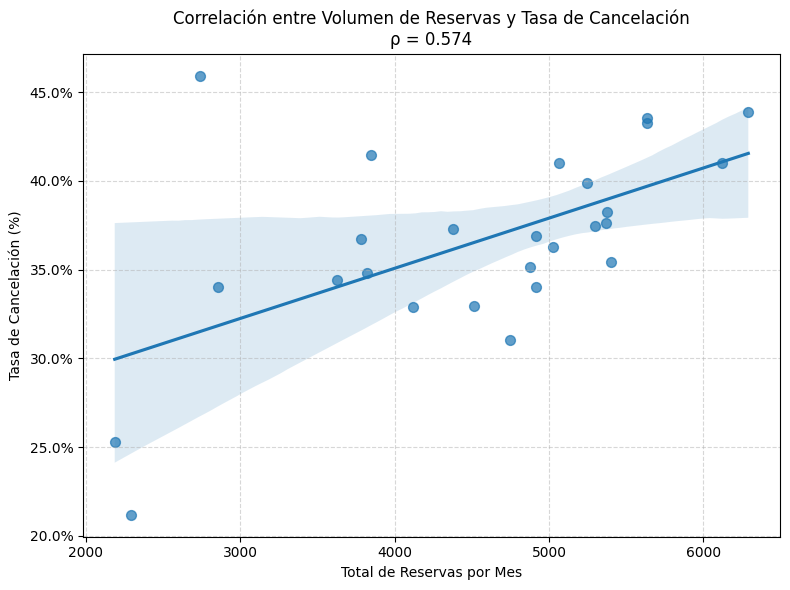

In [115]:
# 1. Carga y asegurarte de que arrival_date esté en datetime
df = pd.read_csv('hotel_bookings_clean.csv')
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# 2. Agrupar por mes (PeriodIndex) y calcular:
#    - total_reservations: cuenta de filas (reservas)
#    - cancellation_rate: media de is_canceled
monthly = (
    df
    .groupby(df['arrival_date'].dt.to_period('M'), observed=False)
    .agg(
        total_reservations=('is_canceled','size'),
        cancellation_rate=('is_canceled','mean')
    )
    .reset_index()
)
# convertir el Period a timestamp para trazar
monthly['month'] = monthly['arrival_date'].dt.to_timestamp()

# 3. Correlación de Pearson
corr_value = monthly['total_reservations'].corr(monthly['cancellation_rate'])
print(f"Coeficiente de correlación (reservas vs tasa de cancelación): {corr_value:.3f}")

# 4. Scatter + línea de regresión
plt.figure(figsize=(8,6))
sns.regplot(
    data=monthly,
    x='total_reservations',
    y='cancellation_rate',
    marker='o',
    scatter_kws={'s':50, 'alpha':0.7}
)
plt.xlabel('Total de Reservas por Mes')
plt.ylabel('Tasa de Cancelación (%)')
plt.title('Correlación entre Volumen de Reservas y Tasa de Cancelación\n'
          f'ρ = {corr_value:.3f}')
# formatear eje Y en %
import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


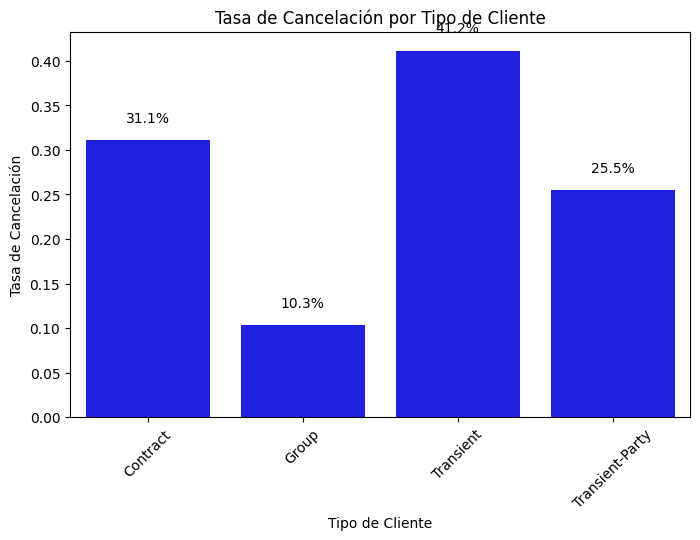

In [12]:
# Calcular la tasa de cancelación por tipo de cliente
customer_type_cancellation = df.groupby('customer_type').agg(
    total_bookings=('is_canceled', 'count'),
    cancellations=('is_canceled', 'sum')
)
customer_type_cancellation['cancellation_rate'] = customer_type_cancellation['cancellations'] / customer_type_cancellation['total_bookings']

# Visualización de la tasa de cancelación por tipo de cliente
plt.figure(figsize=(8, 5))
sns.barplot(
    x=customer_type_cancellation.index,
    y='cancellation_rate',
    data=customer_type_cancellation,
    color='blue'
)
plt.title('Tasa de Cancelación por Tipo de Cliente')
plt.xlabel('Tipo de Cliente')
plt.ylabel('Tasa de Cancelación')
plt.xticks(rotation=45)

# Agregar etiquetas con la tasa de cancelación encima de cada barra
for i, row in customer_type_cancellation.iterrows():
    plt.text(
        i,  # Posición X
        row['cancellation_rate'] + 0.02,  # Posición Y, un poco por encima de la barra
        f"{row['cancellation_rate'] * 100:.1f}%",  # Etiqueta con el valor en porcentaje
        ha='center',  # Alinear el texto al centro
        fontsize=10  # Tamaño de la fuente
    )

plt.show()


## 1. Visualización de la relación entre lead_time y la tasa de cancelación

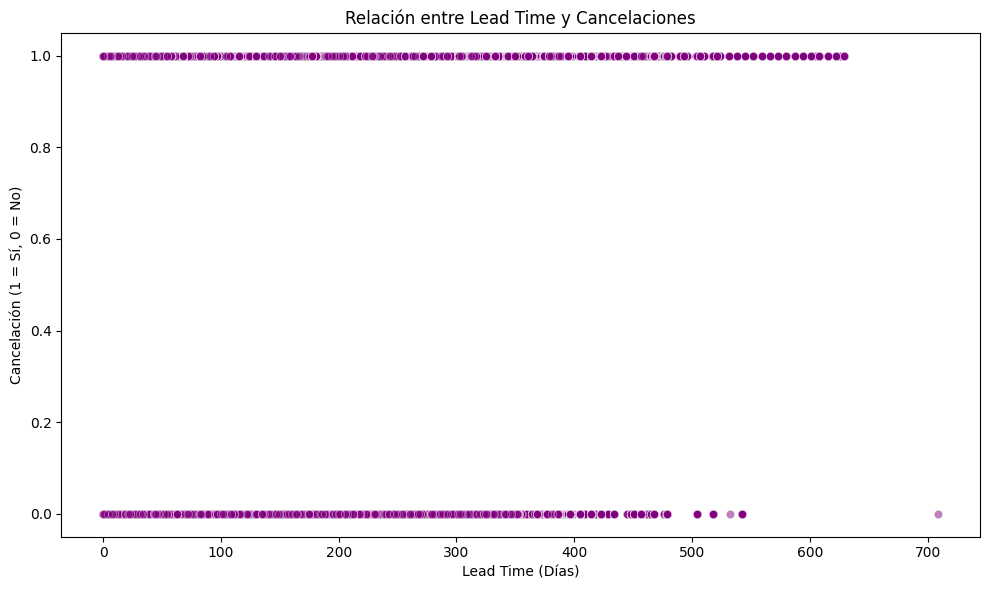

In [14]:
# Visualizar la relación entre 'lead_time' y 'is_canceled'
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='lead_time', 
    y='is_canceled', 
    data=df, 
    color='purple', 
    alpha=0.5
)
plt.title('Relación entre Lead Time y Cancelaciones')
plt.xlabel('Lead Time (Días)')
plt.ylabel('Cancelación (1 = Sí, 0 = No)')
plt.tight_layout()
plt.show()

## 2. Calcular la tasa de cancelación por intervalos de lead_time

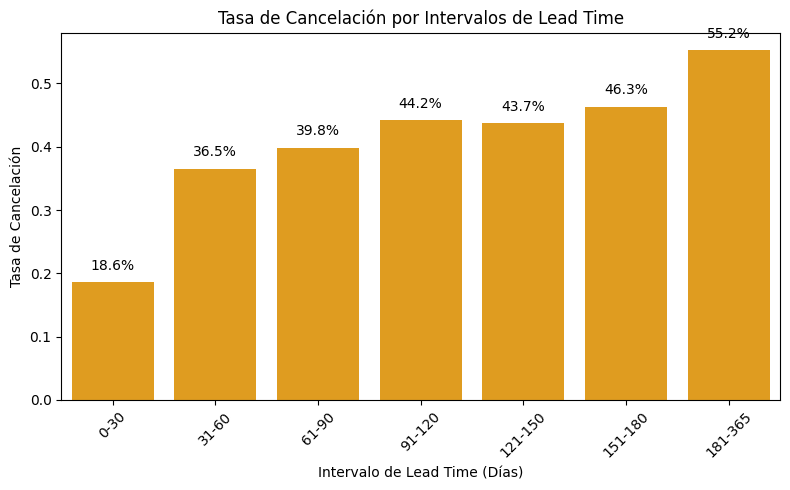

In [56]:
# Crear categorías de lead_time
bins = [0, 30, 60, 90, 120, 150, 180, 365]
labels = ['0-30', '31-60', '61-90', '91-120', '121-150', '151-180', '181-365']
df['lead_time_category'] = pd.cut(df['lead_time'], bins=bins, labels=labels, right=False)

# Calcular tasa de cancelación por categoría de lead_time con observed=False
lead_time_cancellation = df.groupby('lead_time_category', observed=False).agg(
    total_bookings=('is_canceled', 'count'),
    cancellations=('is_canceled', 'sum')
)
lead_time_cancellation['cancellation_rate'] = lead_time_cancellation['cancellations'] / lead_time_cancellation['total_bookings']

# Visualizar la tasa de cancelación por categoría de lead_time
plt.figure(figsize=(8, 5))
sns.barplot(
    x=lead_time_cancellation.index,
    y='cancellation_rate',
    data=lead_time_cancellation,
    color='orange'
)
plt.title('Tasa de Cancelación por Intervalos de Lead Time')
plt.xlabel('Intervalo de Lead Time (Días)')
plt.ylabel('Tasa de Cancelación')
plt.xticks(rotation=45)
plt.tight_layout()

# Agregar etiquetas de datos a cada barra
for i, row in lead_time_cancellation.iterrows():
    plt.text(
        i, 
        row['cancellation_rate'] + 0.02, 
        f"{row['cancellation_rate'] * 100:.1f}%", 
        ha='center', 
        fontsize=10
    )

plt.show()


## relacion entre lead time y cancelaciones

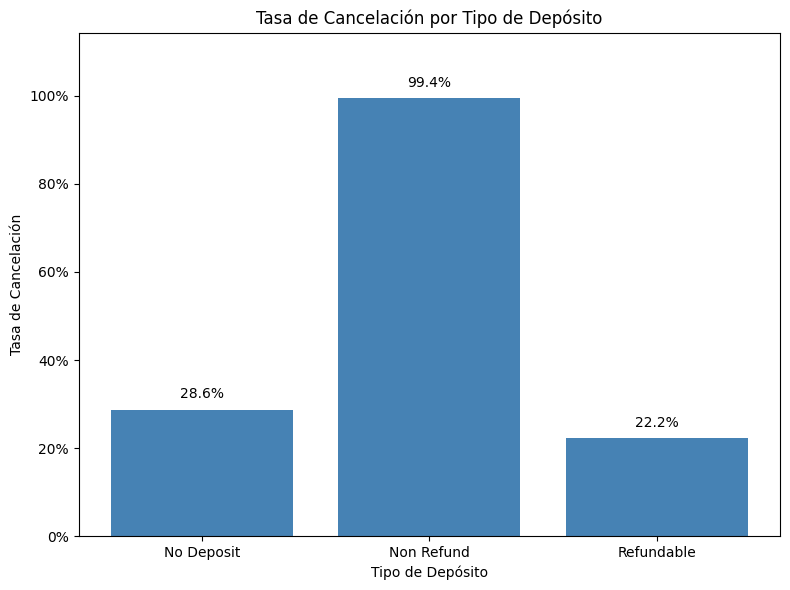

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# 1. Carga de datos
df = pd.read_csv('hotel_bookings_clean.csv')

# 2. Agrupar por tipo de depósito y calcular tasa de cancelación
deposit = (
    df
    .groupby('deposit_type', observed=False)
    .agg(
        total=('is_canceled', 'size'),
        canceled=('is_canceled', 'sum')
    )
    .reset_index()
)
deposit['cancel_rate'] = deposit['canceled'] / deposit['total']

# 3. Dibujar el barplot con Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(
    deposit['deposit_type'],
    deposit['cancel_rate'],
    color='steelblue'
)

# 4. Formatear eje Y como porcentaje
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.set_ylim(0, deposit['cancel_rate'].max() * 1.15)

# 5. Anotar porcentajes encima de cada barra
for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h + 0.02,
        f"{h * 100:.1f}%",
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

# 6. Etiquetas y título
ax.set_xlabel('Tipo de Depósito')
ax.set_ylabel('Tasa de Cancelación')
ax.set_title('Tasa de Cancelación por Tipo de Depósito')

plt.tight_layout()
plt.show()

In [105]:
import pandas as pd
from IPython.display import display

# 1. Carga del dataset
df = pd.read_csv('hotel_bookings_clean.csv')

# 2. Total de registros por tipo de depósito
total_by_deposit = (
    df['deposit_type']
      .value_counts()
      .reset_index()
      .rename(columns={'index':'deposit_type', 'deposit_type':'total_records'})
)
print("Total de registros por tipo de depósito:")
display(total_by_deposit)

# 3. Filtrar solo "Non Refund"
non_refund = df[df['deposit_type'] == 'Non Refund']

# 4. Agrupar por reservation_status para Non Refund, obteniendo conteo y proporción
status_summary = (
    non_refund
      .groupby('reservation_status', observed=False)
      .agg(count=('reservation_status','size'))
      .reset_index()
)
# añadir proporción
status_summary['proportion'] = status_summary['count'] / status_summary['count'].sum()

print("\nConteo y proporción de reservation_status en 'Non Refund':")
display(status_summary)


Total de registros por tipo de depósito:


,total_records,count
0,No Deposit,103353
1,Non Refund,14572
2,Refundable,162



Conteo y proporción de reservation_status en 'Non Refund':


,reservation_status,count,proportion
0,Canceled,14445,0.991285
1,Check-Out,93,0.006382
2,No-Show,34,0.002333


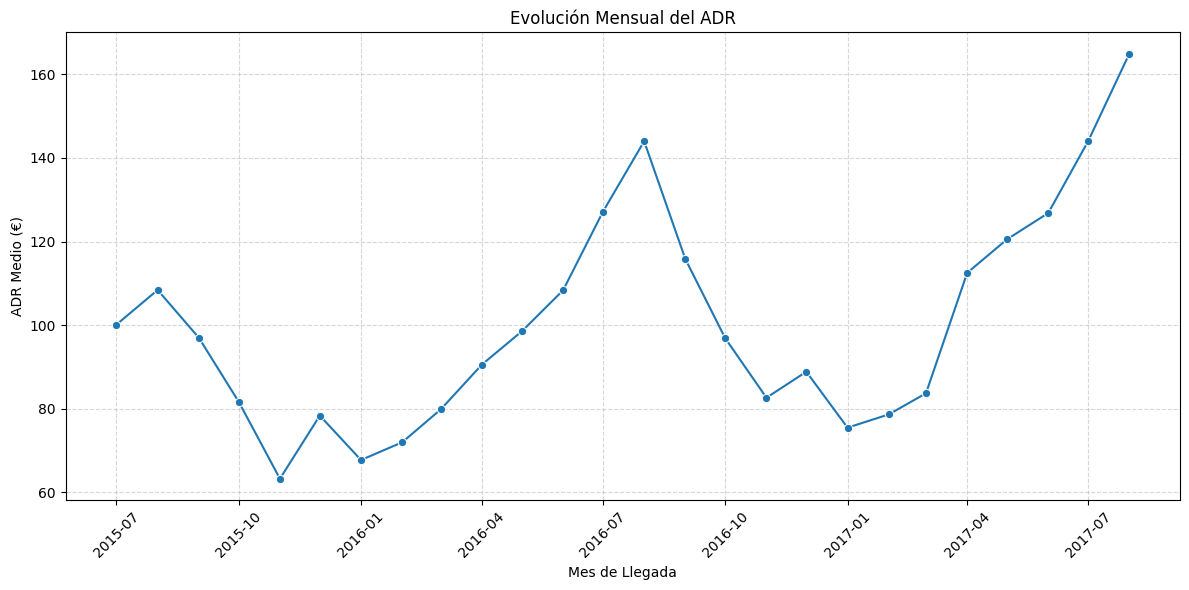

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Carga del dataset
df = pd.read_csv('hotel_bookings_clean.csv')

# 2. Convertir arrival_date a datetime
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# 3. Agregación mensual de ADR medio
adr_monthly = (
    df
    .groupby(df['arrival_date'].dt.to_period('M'), observed=False)['adr']
    .mean()
    .reset_index(name='adr_mean')
)
# Convertir el PeriodIndex a timestamps para plotear
adr_monthly['month'] = adr_monthly['arrival_date'].dt.to_timestamp()

# 4. Plot de evolución del ADR
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=adr_monthly,
    x='month',
    y='adr_mean',
    marker='o'
)

# 5. Etiquetas y estilo
plt.xlabel('Mes de Llegada')
plt.ylabel('ADR Medio (€)')
plt.title('Evolución Mensual del ADR')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Coeficiente de correlación (reservas vs tasa de cancelación): 0.574


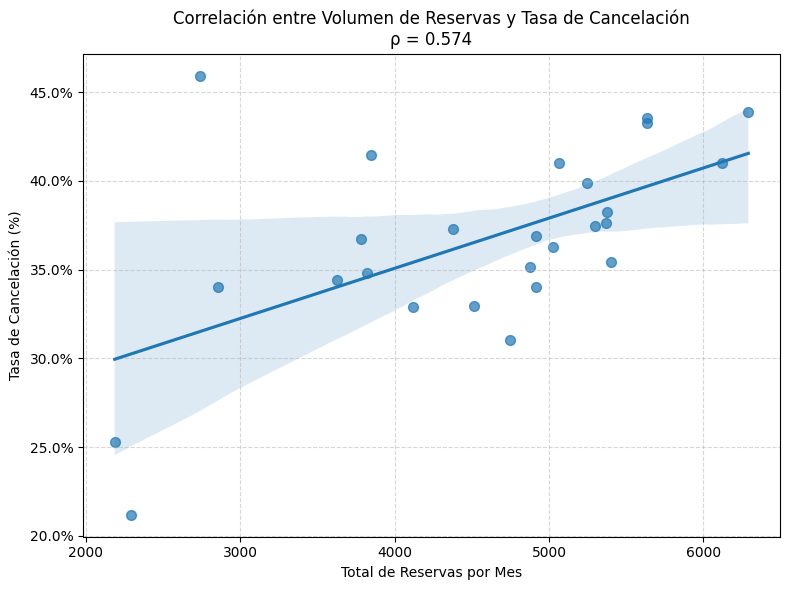

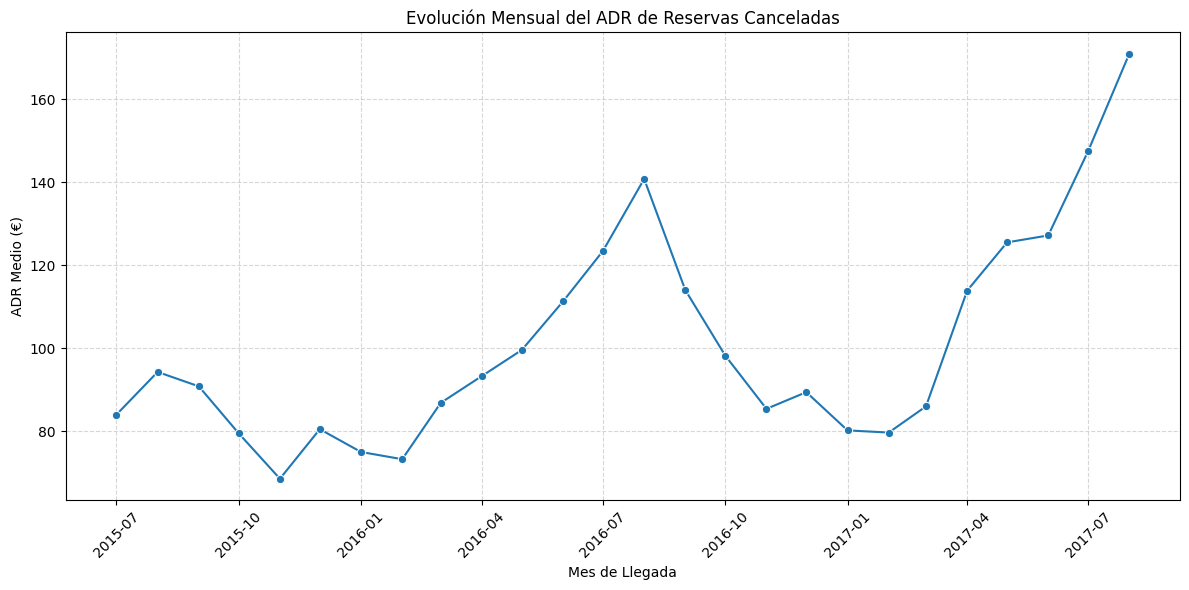

In [119]:
# 3. Filtrar solo las reservas canceladas
canceled = df[df['is_canceled'] == 1]

# 4. Agrupar por mes y calcular ADR medio
adr_cancel_trend = (
    canceled
      .groupby(canceled['arrival_date'].dt.to_period('M'), observed=False)['adr']
      .mean()
      .reset_index(name='adr_mean')
)
# Convertir el PeriodIndex a timestamps para el eje X
adr_cancel_trend['month'] = adr_cancel_trend['arrival_date'].dt.to_timestamp()

# 5. Graficar la evolución mensual del ADR para canceladas
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=adr_cancel_trend,
    x='month',
    y='adr_mean',
    marker='o'
)
plt.xlabel('Mes de Llegada')
plt.ylabel('ADR Medio (€)')
plt.title('Evolución Mensual del ADR de Reservas Canceladas')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



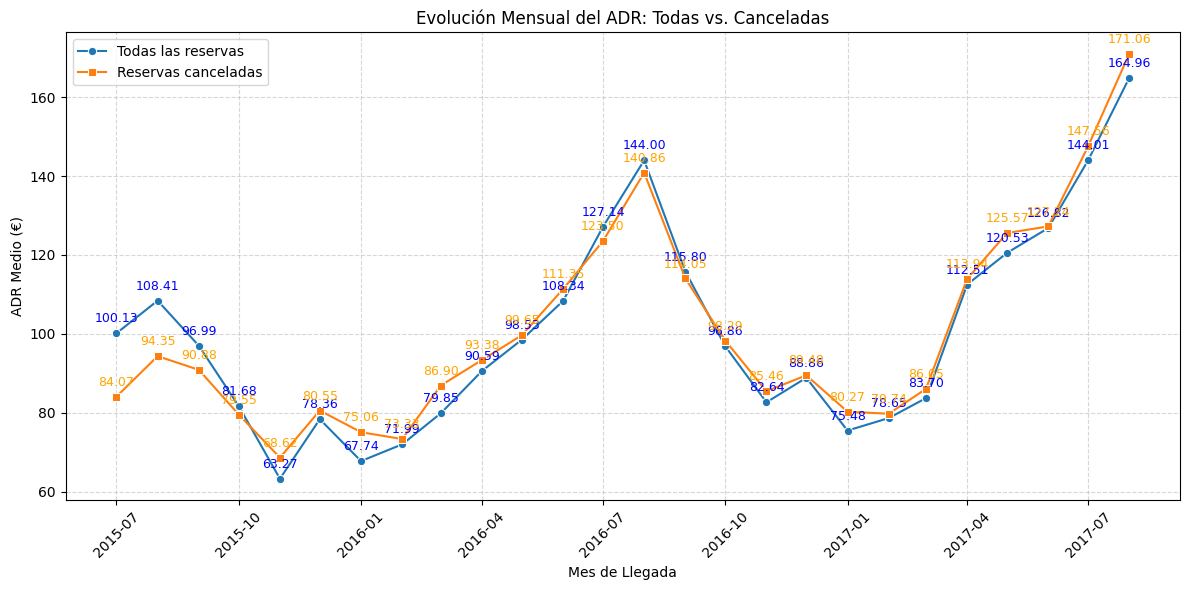

In [129]:
# 2. Cálculo de ADR mensual para todas las reservas
adr_all = (
    df
    .groupby(df['arrival_date'].dt.to_period('M'), observed=False)
    .agg(adr_mean=('adr', 'mean'))
    .reset_index()
)
adr_all['month'] = adr_all['arrival_date'].dt.to_timestamp()

# 3. Cálculo de ADR mensual solo para reservas canceladas
canceled = df[df['is_canceled'] == 1]
adr_cancel = (
    canceled
    .groupby(canceled['arrival_date'].dt.to_period('M'), observed=False)
    .agg(adr_mean=('adr', 'mean'))
    .reset_index()
)
adr_cancel['month'] = adr_cancel['arrival_date'].dt.to_timestamp()

# 4. Graficar ambas series
fig, ax = plt.subplots(figsize=(12, 6))

# Línea de ADR para todas las reservas
sns.lineplot(
    ax=ax,
    data=adr_all,
    x='month',
    y='adr_mean',
    marker='o',
    label='Todas las reservas'
)
# Anotar cada punto
for x, y in zip(adr_all['month'], adr_all['adr_mean']):
    ax.text(
        x, y + 2,               # ajusta "+ 2" según tu escala de ADR
        f"{y:.2f}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='blue'
    )

# Línea de ADR para reservas canceladas
sns.lineplot(
    ax=ax,
    data=adr_cancel,
    x='month',
    y='adr_mean',
    marker='s',
    label='Reservas canceladas'
)
# Anotar cada punto
for x, y in zip(adr_cancel['month'], adr_cancel['adr_mean']):
    ax.text(
        x, y + 2,
        f"{y:.2f}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='orange'
    )

# 5. Estilo y etiquetas
ax.set_xlabel('Mes de Llegada')
ax.set_ylabel('ADR Medio (€)')
ax.set_title('Evolución Mensual del ADR: Todas vs. Canceladas')
ax.legend(title='')
ax.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## grafico de lineas donde se muestre la evolucion del adr en funcion del customer_type

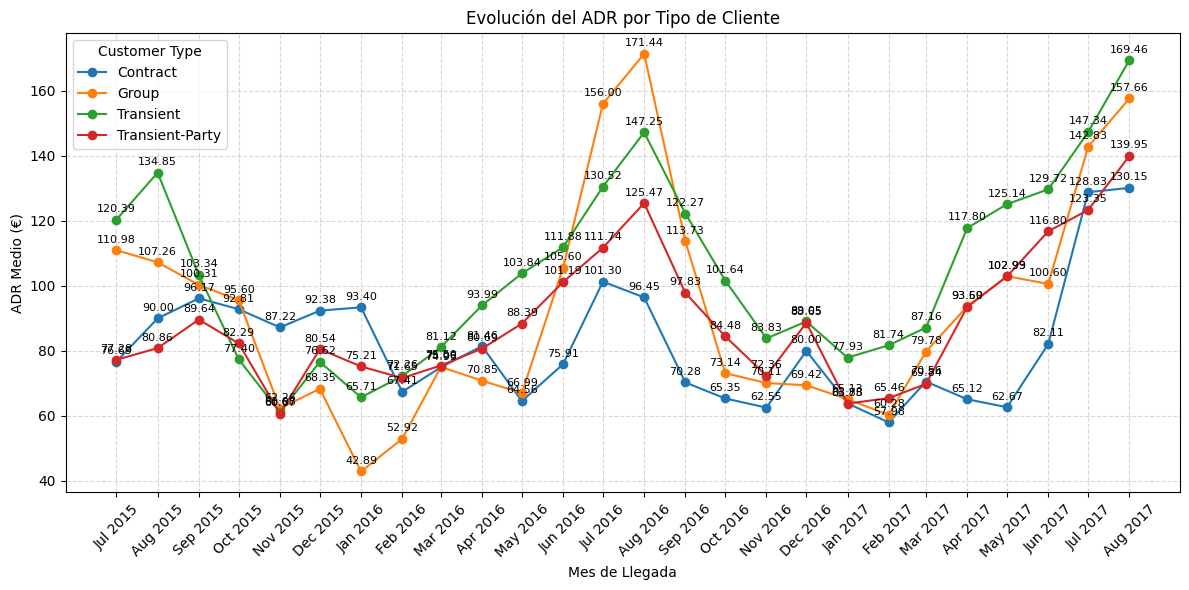

In [140]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carga y conversión de fecha
df = pd.read_csv('hotel_bookings_clean.csv')
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# 2. Agrupar por mes y customer_type y calcular ADR medio
grouped = (
    df
    .groupby([df['arrival_date'].dt.to_period('M'), 'customer_type'], observed=False)
    .agg(adr_mean=('adr', 'mean'))
    .reset_index()
)
grouped['month'] = grouped['arrival_date'].dt.to_timestamp()

# 3. Pivot para facilitar el plot
pivot_df = grouped.pivot(index='month', columns='customer_type', values='adr_mean')

# 4. Gráfico de líneas con anotaciones
fig, ax = plt.subplots(figsize=(12, 6))
for ctype in pivot_df.columns:
    ax.plot(
        pivot_df.index, 
        pivot_df[ctype], 
        marker='o', 
        label=ctype
    )
    for x, y in zip(pivot_df.index, pivot_df[ctype]):
        ax.text(
            x, y + pivot_df.values.max() * 0.01,
            f"{y:.2f}",
            ha='center', va='bottom', fontsize=8
        )

# 5. Estilo y etiquetas
ax.set_xlabel('Mes de Llegada')
ax.set_ylabel('ADR Medio (€)')
ax.set_title('Evolución del ADR por Tipo de Cliente')
ax.set_xticks(pivot_df.index)
ax.set_xticklabels([d.strftime('%b %Y') for d in pivot_df.index], rotation=45)
ax.legend(title='Customer Type')
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Evolucion del adr en funcion del customer_type (reservas canceladas)

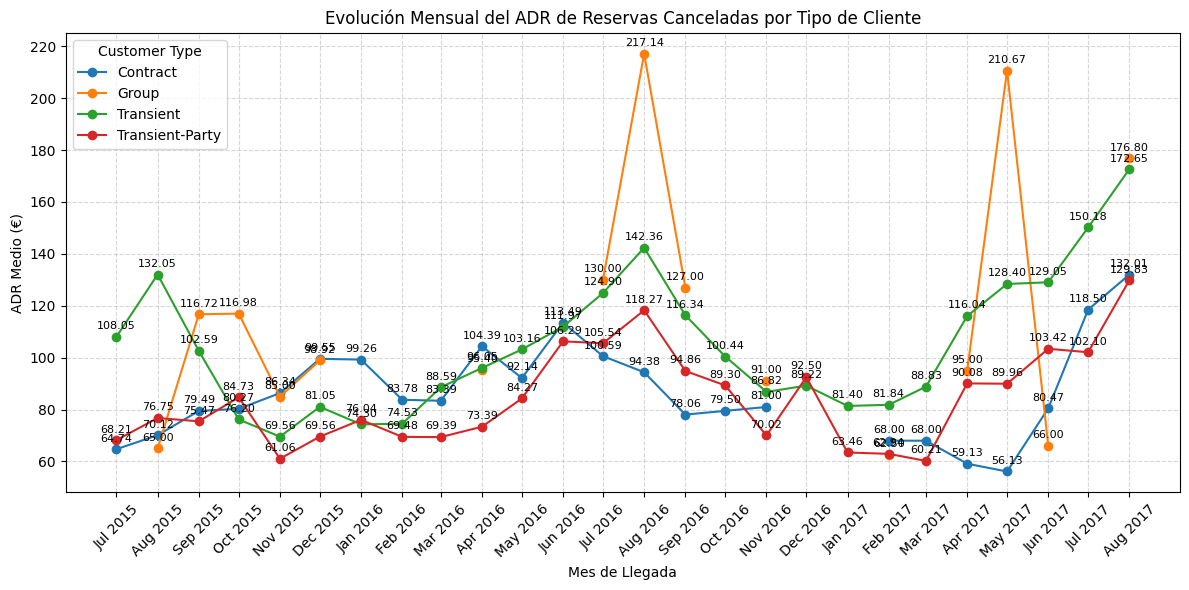

In [144]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carga y conversión de fecha
df = pd.read_csv('hotel_bookings_clean.csv')
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# 2. Filtrar solo las reservas canceladas
cancelled = df[df['is_canceled'] == 1].copy()

# 3. Agrupar por mes y customer_type, calcular ADR medio
grouped_cancel = (
    cancelled
    .groupby([cancelled['arrival_date'].dt.to_period('M'), 'customer_type'], observed=False)
    .agg(adr_mean=('adr', 'mean'))
    .reset_index()
)
# Convertir el periodo a timestamp para el eje X
grouped_cancel['month'] = grouped_cancel['arrival_date'].dt.to_timestamp()

# 4. Pivot para tener una columna por tipo de cliente
pivot_cancel = grouped_cancel.pivot(
    index='month', 
    columns='customer_type', 
    values='adr_mean'
)

# 5. Graficar líneas con anotaciones
fig, ax = plt.subplots(figsize=(12, 6))
max_adr = pivot_cancel.max().max()

for ctype in pivot_cancel.columns:
    ax.plot(
        pivot_cancel.index,
        pivot_cancel[ctype],
        marker='o',
        label=ctype
    )
    # Anotar cada punto
    for x, y in zip(pivot_cancel.index, pivot_cancel[ctype]):
        ax.text(
            x,
            y + max_adr * 0.01,
            f"{y:.2f}",
            ha='center',
            va='bottom',
            fontsize=8
        )

# 6. Estilo y etiquetas
ax.set_xlabel('Mes de Llegada')
ax.set_ylabel('ADR Medio (€)')
ax.set_title('Evolución Mensual del ADR de Reservas Canceladas por Tipo de Cliente')
ax.set_xticks(pivot_cancel.index)
ax.set_xticklabels([d.strftime('%b %Y') for d in pivot_cancel.index], rotation=45)
ax.legend(title='Customer Type')
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


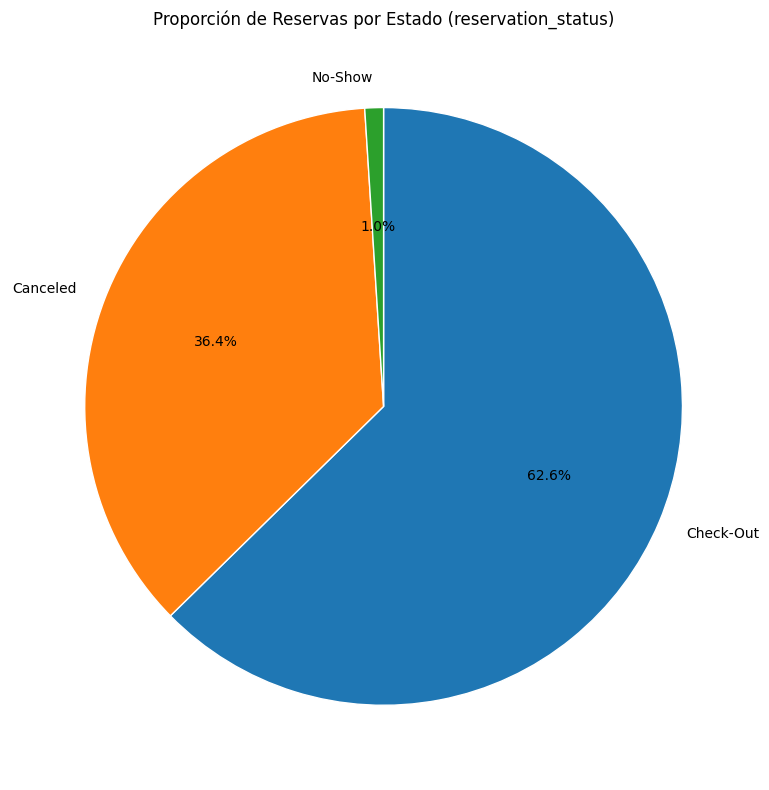

In [146]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carga del dataset
df = pd.read_csv('hotel_bookings_clean.csv')

# 2. Conteo de reservation_status
status_counts = df['reservation_status'].value_counts()

# 3. Gráfico de tarta
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    status_counts,
    labels=status_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'}
)

# 4. Estilo y título
ax.set_title('Proporción de Reservas por Estado (reservation_status)')
plt.tight_layout()
plt.show()


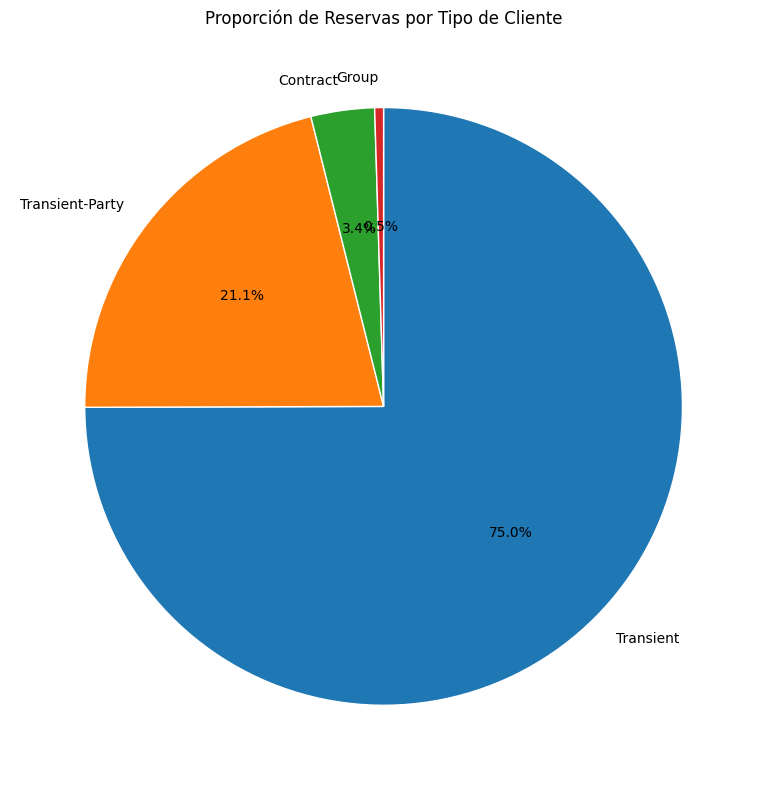

In [148]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carga del dataset
df = pd.read_csv('hotel_bookings_clean.csv')

# 2. Conteo de customer_type
type_counts = df['customer_type'].value_counts()

# 3. Gráfico de tarta
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    type_counts,
    labels=type_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'}
)

# 4. Estilo y título
ax.set_title('Proporción de Reservas por Tipo de Cliente')
plt.tight_layout()
plt.show()


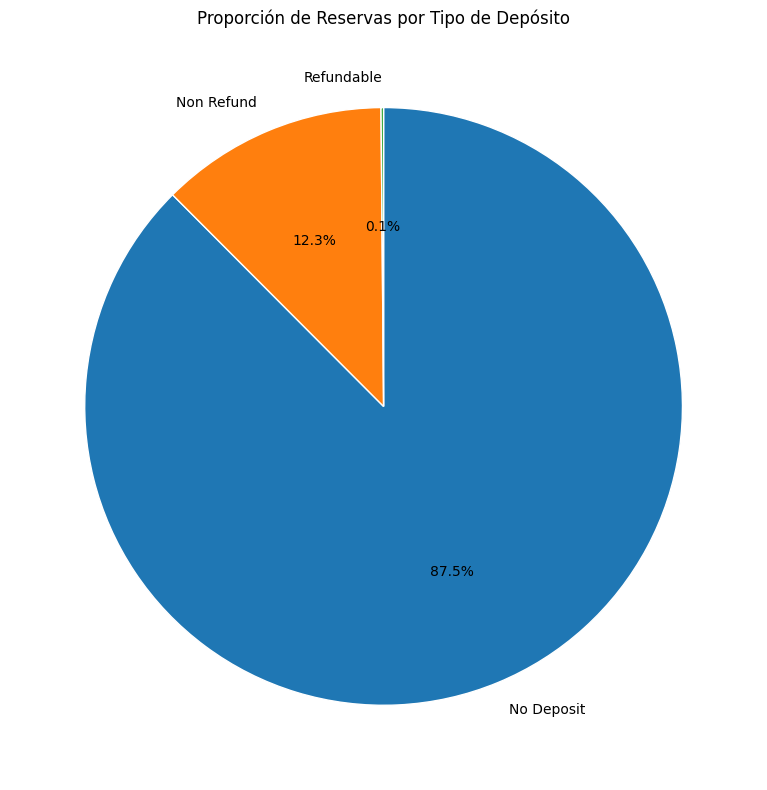

In [150]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carga del dataset
df = pd.read_csv('hotel_bookings_clean.csv')

# 2. Conteo de deposit_type
deposit_counts = df['deposit_type'].value_counts()

# 3. Gráfico de tarta
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    deposit_counts,
    labels=deposit_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'}
)

# 4. Estilo y título
ax.set_title('Proporción de Reservas por Tipo de Depósito')
plt.tight_layout()
plt.show()


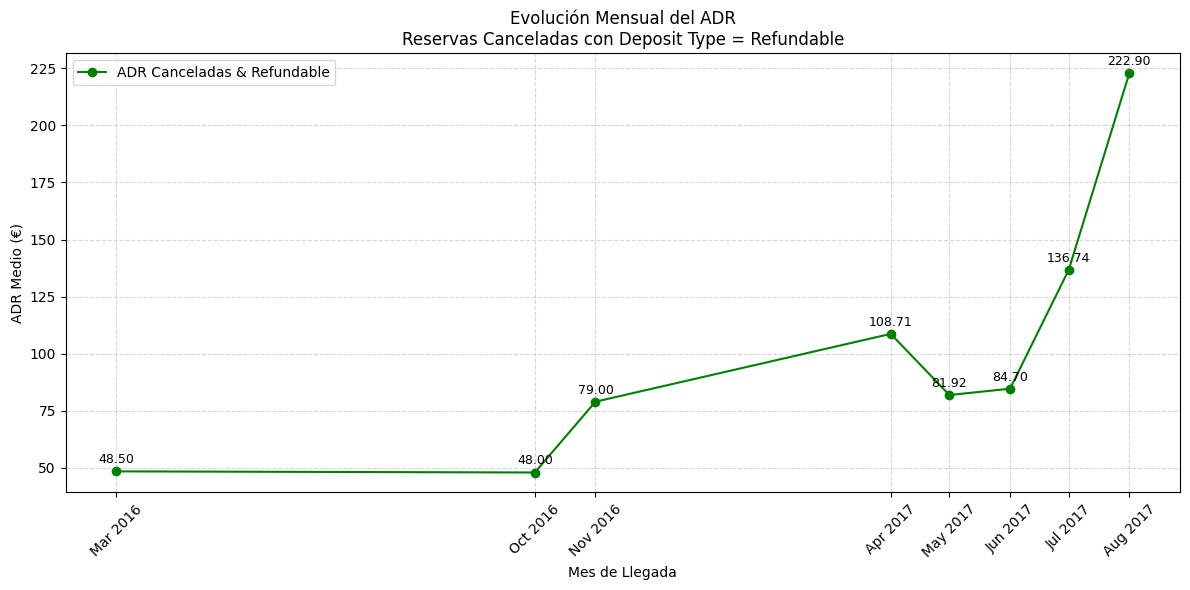

In [152]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carga y conversión a datetime
df = pd.read_csv('hotel_bookings_clean.csv')
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# 2. Filtrar solo las reservas canceladas con deposit_type "Refundable"
mask = (df['is_canceled'] == 1) & (df['deposit_type'] == 'Refundable')
df_refund_cancel = df[mask].copy()

# 3. Agrupar por mes y calcular ADR medio
adr_refund_cancel = (
    df_refund_cancel
      .groupby(df_refund_cancel['arrival_date'].dt.to_period('M'), observed=False)
      .agg(adr_mean=('adr', 'mean'))
      .reset_index()
)
adr_refund_cancel['month'] = adr_refund_cancel['arrival_date'].dt.to_timestamp()

# 4. Graficar la evolución del ADR
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    adr_refund_cancel['month'],
    adr_refund_cancel['adr_mean'],
    marker='o',
    color='green',
    label='ADR Canceladas & Refundable'
)

# 5. Añadir etiquetas de datos encima de cada punto
max_adr = adr_refund_cancel['adr_mean'].max()
for x, y in zip(adr_refund_cancel['month'], adr_refund_cancel['adr_mean']):
    ax.text(
        x, y + max_adr * 0.01,
        f"{y:.2f}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

# 6. Estilo y etiquetas
ax.set_xlabel('Mes de Llegada')
ax.set_ylabel('ADR Medio (€)')
ax.set_title('Evolución Mensual del ADR\nReservas Canceladas con Deposit Type = Refundable')
ax.set_xticks(adr_refund_cancel['month'])
ax.set_xticklabels([d.strftime('%b %Y') for d in adr_refund_cancel['month']], rotation=45)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
